# CSCI 250: Project 6 - Lucy Buhayenko

## Importing Libraries

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score

## Student Lifestyle Dataset

In [349]:
df = pd.read_csv("student_lifestyle_dataset.csv")

## I drop ID column and define X and y.
### ID column is not userful because it's an identifier. My target is Stress Level column. 



In [350]:
X = df.drop(columns=["Student_ID", "Stress_Level"])
y = df["Stress_Level"]

## Encode target:
### Low Stress = 0; Moderate Stress = 1; High Stress = 2


In [351]:
y = y.map({"Low": 0, "Moderate": 1, "High": 2})

## Correlation
### I need to delete Study_Hours_Per_Day because it's highly positively correlated with GPA

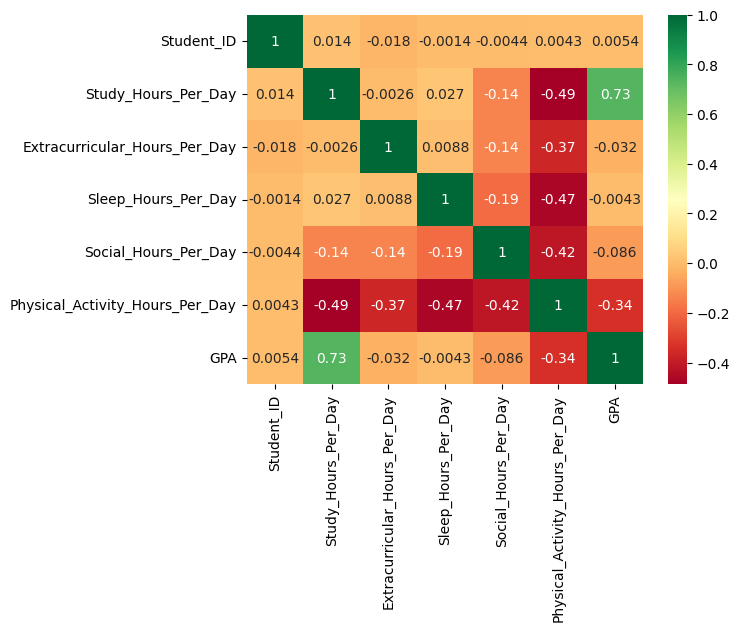

In [352]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdYlGn')
plt.show()

## I drop Study_Hours_Per_Day and redefine X

In [353]:
X = df.drop(columns=["Student_ID", "Stress_Level", "Study_Hours_Per_Day"])

## Split data into Train and Test


In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaler

In [355]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

## I'm finding the best number of neighbors (k) for my kNN model using 5-fold cross-validation.


### My best k in this case is k=16 becuase it has 77% cross-validated accuracy

In [ ]:
Kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mean_acc_scores = []
ks = [i for i in range(1, 21)]

# Convert y_train to numpy array
y_train_np = np.array(y_train)

for k in ks:
    acc_scores = []
    for train_idx, val_idx in Kfold.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_np[train_idx], y_train_np[val_idx]

        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_tr, y_tr)
        acc = knn.score(X_val, y_val)
        acc_scores.append(acc)

    mean_acc_scores.append(np.mean(acc_scores))

print(f"Ks: {ks}")
print(f"Mean cross-validated accuracies: {mean_acc_scores}")

Ks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Mean cross-validated accuracies: [np.float64(0.7507142857142857), np.float64(0.7271428571428571), np.float64(0.7657142857142857), np.float64(0.7592857142857142), np.float64(0.7571428571428571), np.float64(0.7635714285714286), np.float64(0.7628571428571429), np.float64(0.7628571428571428), np.float64(0.7571428571428571), np.float64(0.7585714285714286), np.float64(0.7592857142857142), np.float64(0.7678571428571428), np.float64(0.7592857142857142), np.float64(0.7657142857142857), np.float64(0.7664285714285713), np.float64(0.7707142857142857), np.float64(0.7664285714285713), np.float64(0.7664285714285713), np.float64(0.7621428571428571), np.float64(0.7557142857142857)]



## Plotting graph mean cross-validated accuracy vs k:
### Graph shows that my best k is indeed 16, since it's the highest point on the graph

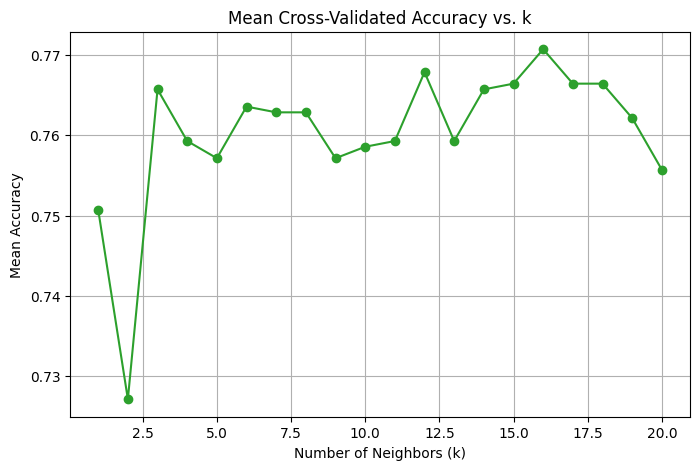

In [357]:
plt.figure(figsize=(8,5))
plt.plot(ks, mean_acc_scores, color='tab:green', marker="o")
plt.title('Mean Cross-Validated Accuracy vs. k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.grid(True)

In [358]:
knn = neighbors.KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with k={16}: {accuracy}")

Test set accuracy with k=16: 0.7833333333333333


## PCA to reduce to 2 dimensions

In [359]:
pca = PCA(n_components=2)
pca.fit(X_train_scaled)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


## Train Plot:
### The background colors(green, orange and blue) show which class the kNN model would predict a point in that region. They are decision boundries. The dots are data points. Each dot represents a sample from the training dataset. The color of the dot represents its true class label. Areas with same color mean that new points in there will be classified into that same class. The overlapping areas mean that classes are not easily separable(kNN will struggle there). K = 16 means that 16 closest neighbours are used to decide each point's class. The central area - orange color has points of 3 classes mixed heavily, this means that the classes are not perfectly separable in these two principal components. K=16 means that the decision boundary is fairly smooth and there is low variance. There are smooth regions which means that kNN is generalizing moderately well. 

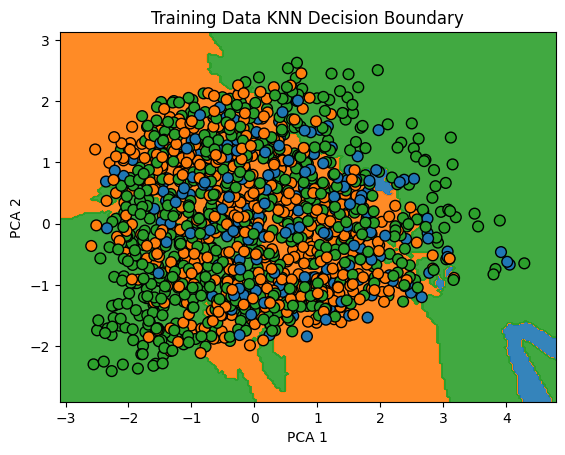

In [360]:
X2_train = pca.transform(X_train_scaled)

# axis limits
x_min, x_max = X2_train[:, 0].min() - 0.5, X2_train[:, 0].max() + 0.5
y_min, y_max = X2_train[:, 1].min() - 0.5, X2_train[:, 1].max() + 0.5

#meshgrid
feature1, feature2 = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid = np.vstack([feature1.ravel(), feature2.ravel()]).T
inv = pca.inverse_transform(grid)

# Predict
y_pred_grid = np.reshape(knn.predict(inv), feature1.shape)

#Colormap
base_cmap = plt.cm.tab10
region_colors = ListedColormap(base_cmap.colors[:3])
point_colors = ListedColormap(base_cmap.colors[:3])

#Decision boundary
display = DecisionBoundaryDisplay(xx0=feature1, xx1=feature2, response=y_pred_grid)
display.plot(cmap=region_colors, alpha=0.9)

#Plotting points
display.ax_.scatter(X2_train[:, 0], X2_train[:, 1], c=y_train_np, cmap=point_colors,
                    edgecolor="black", s=60)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Training Data KNN Decision Boundary")
plt.show()

## Test Plot
### In this case, the plot also shows 3 classes - orange, green and blue. All of the dots' colors show the true class of the point. In this case, the orange area, similarly to the training set, has a big overlap of 3 classes' points, which means that the classes are not clearly separated. The model finds it hard to tell the points apart because they look similar in those features(PCA1 and PCA2). This means that kNN might make mistakes predicting the right class sometimes. Also, just like in training set, the testing set uses k=16 meaning it finds 16 nearest neighbours and decided on class based on the points. 

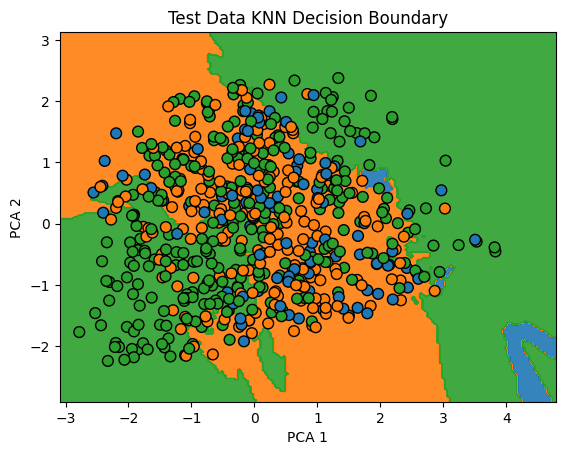

In [361]:
X2_test = pca.transform(X_test_scaled)  

#same axis limits as training
feature1, feature2 = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid = np.vstack([feature1.ravel(), feature2.ravel()]).T
inv = pca.inverse_transform(grid)

# Predict
y_pred_grid = np.reshape(knn.predict(inv), feature1.shape)

#Decision boundary
display = DecisionBoundaryDisplay(xx0=feature1, xx1=feature2, response=y_pred_grid)
display.plot(cmap=region_colors, alpha=0.9)

#plot points
display.ax_.scatter(X2_test[:, 0], X2_test[:, 1], c=y_test.to_numpy(), cmap=point_colors,
                    edgecolor="black", s=60)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Test Data KNN Decision Boundary")
plt.show()